In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from thoi.heuristics.simulated_annealing_multi_order import simulated_annealing_multi_order
from thoi.measures.gaussian_copula import nplets_measures

/home/laouen.belloli/Documents/git/THOI/thoi/measures/gaussian_copula.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


<AxesSubplot:>

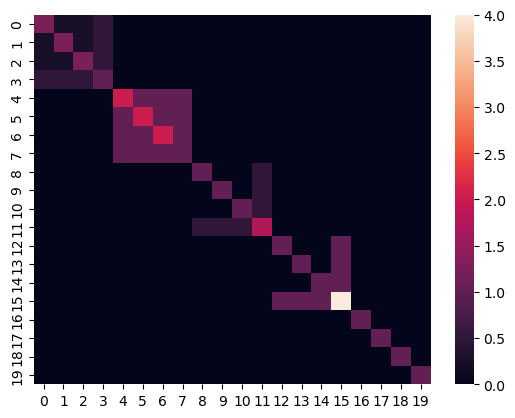

In [2]:
N = 20
T = 100000

covmat = np.load(f'/home/laouen.belloli/Documents/data/Oinfo/tt_hh/N-{N}_example_covmat.npy')
N = covmat.shape[0]

X = np.random.multivariate_normal(np.zeros(N), covmat, T)

# plot covmat as heatmap
sns.heatmap(covmat)

In [3]:
n = N // 5
npletas_sub_sistemas = np.stack([np.arange(i, i+n) for i in range(0, N, n)])
print(npletas_sub_sistemas)
measures_sub_systems = nplets_measures(X, npletas_sub_sistemas)
print(measures_sub_systems)

# sum the o info of the two synergistic sub-systems
min_o = measures_sub_systems[2:4, 2].sum().item()
print('MIN O info:', min_o)

[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]
 [16 17 18 19]]
tensor([[ 3.3973e-01,  2.8186e-01,  5.7872e-02,  6.2159e-01],
        [ 1.0397e+00,  6.9417e-01,  3.4552e-01,  1.7339e+00],
        [ 2.8039e-01,  3.3538e-01, -5.4993e-02,  6.1577e-01],
        [ 6.9796e-01,  1.0502e+00, -3.5225e-01,  1.7482e+00],
        [ 4.1441e-05,  4.0697e-05,  7.4426e-07,  8.2138e-05]], device='cuda:0',
       dtype=torch.float64)
MIN O info: -0.4072388048955524


In [4]:
CORRECT = np.concatenate([
    [0 for i in range(2*n)],
    [1 for i in range(2*n)],
    [0 for i in range(n)]
])

def single_error_rates(nplets):
    return (nplets.numpy() == CORRECT).sum(axis=0)/nplets.shape[0]

def weigth_absolute_deviation(nplets):
    weigth = np.concatenate([
        [1 for i in range(4*n)],
        [0.5 for i in range(n)]
    ])
    elements_errors = np.abs(nplets.numpy() - CORRECT)
    weigthed_errors = np.multiply(elements_errors, weigth)
    errors = np.sum(weigthed_errors, axis=1)
    return errors

var_names = (
        [r'$TTw_{{y}}$'] + [rf'$TTw_{{x}}$' for i in range(n-1)] +
        [r'$TTs_{{y}}$'] + [rf'$TTs_{{x}}$' for i in range(n-1)] +
        [r'$HHw_{{y}}$'] + [rf'$HHw_{{x}}$' for i in range(n-1)] +
        [r'$HHs_{{y}}$'] + [rf'$HHs_{{x}}$' for i in range(n-1)] +
        [rf'$X_{i}$' for i in range(n)]
    )

mean(O) = -0.3584771827837821 - ES: 99:  37%|███▋      | 367/1000 [00:12<00:21, 29.13it/s]


Early stop reached


mean(O) = -0.4072645268724715 - ES: 0: 100%|██████████| 1000/1000 [00:34<00:00, 29.17it/s]


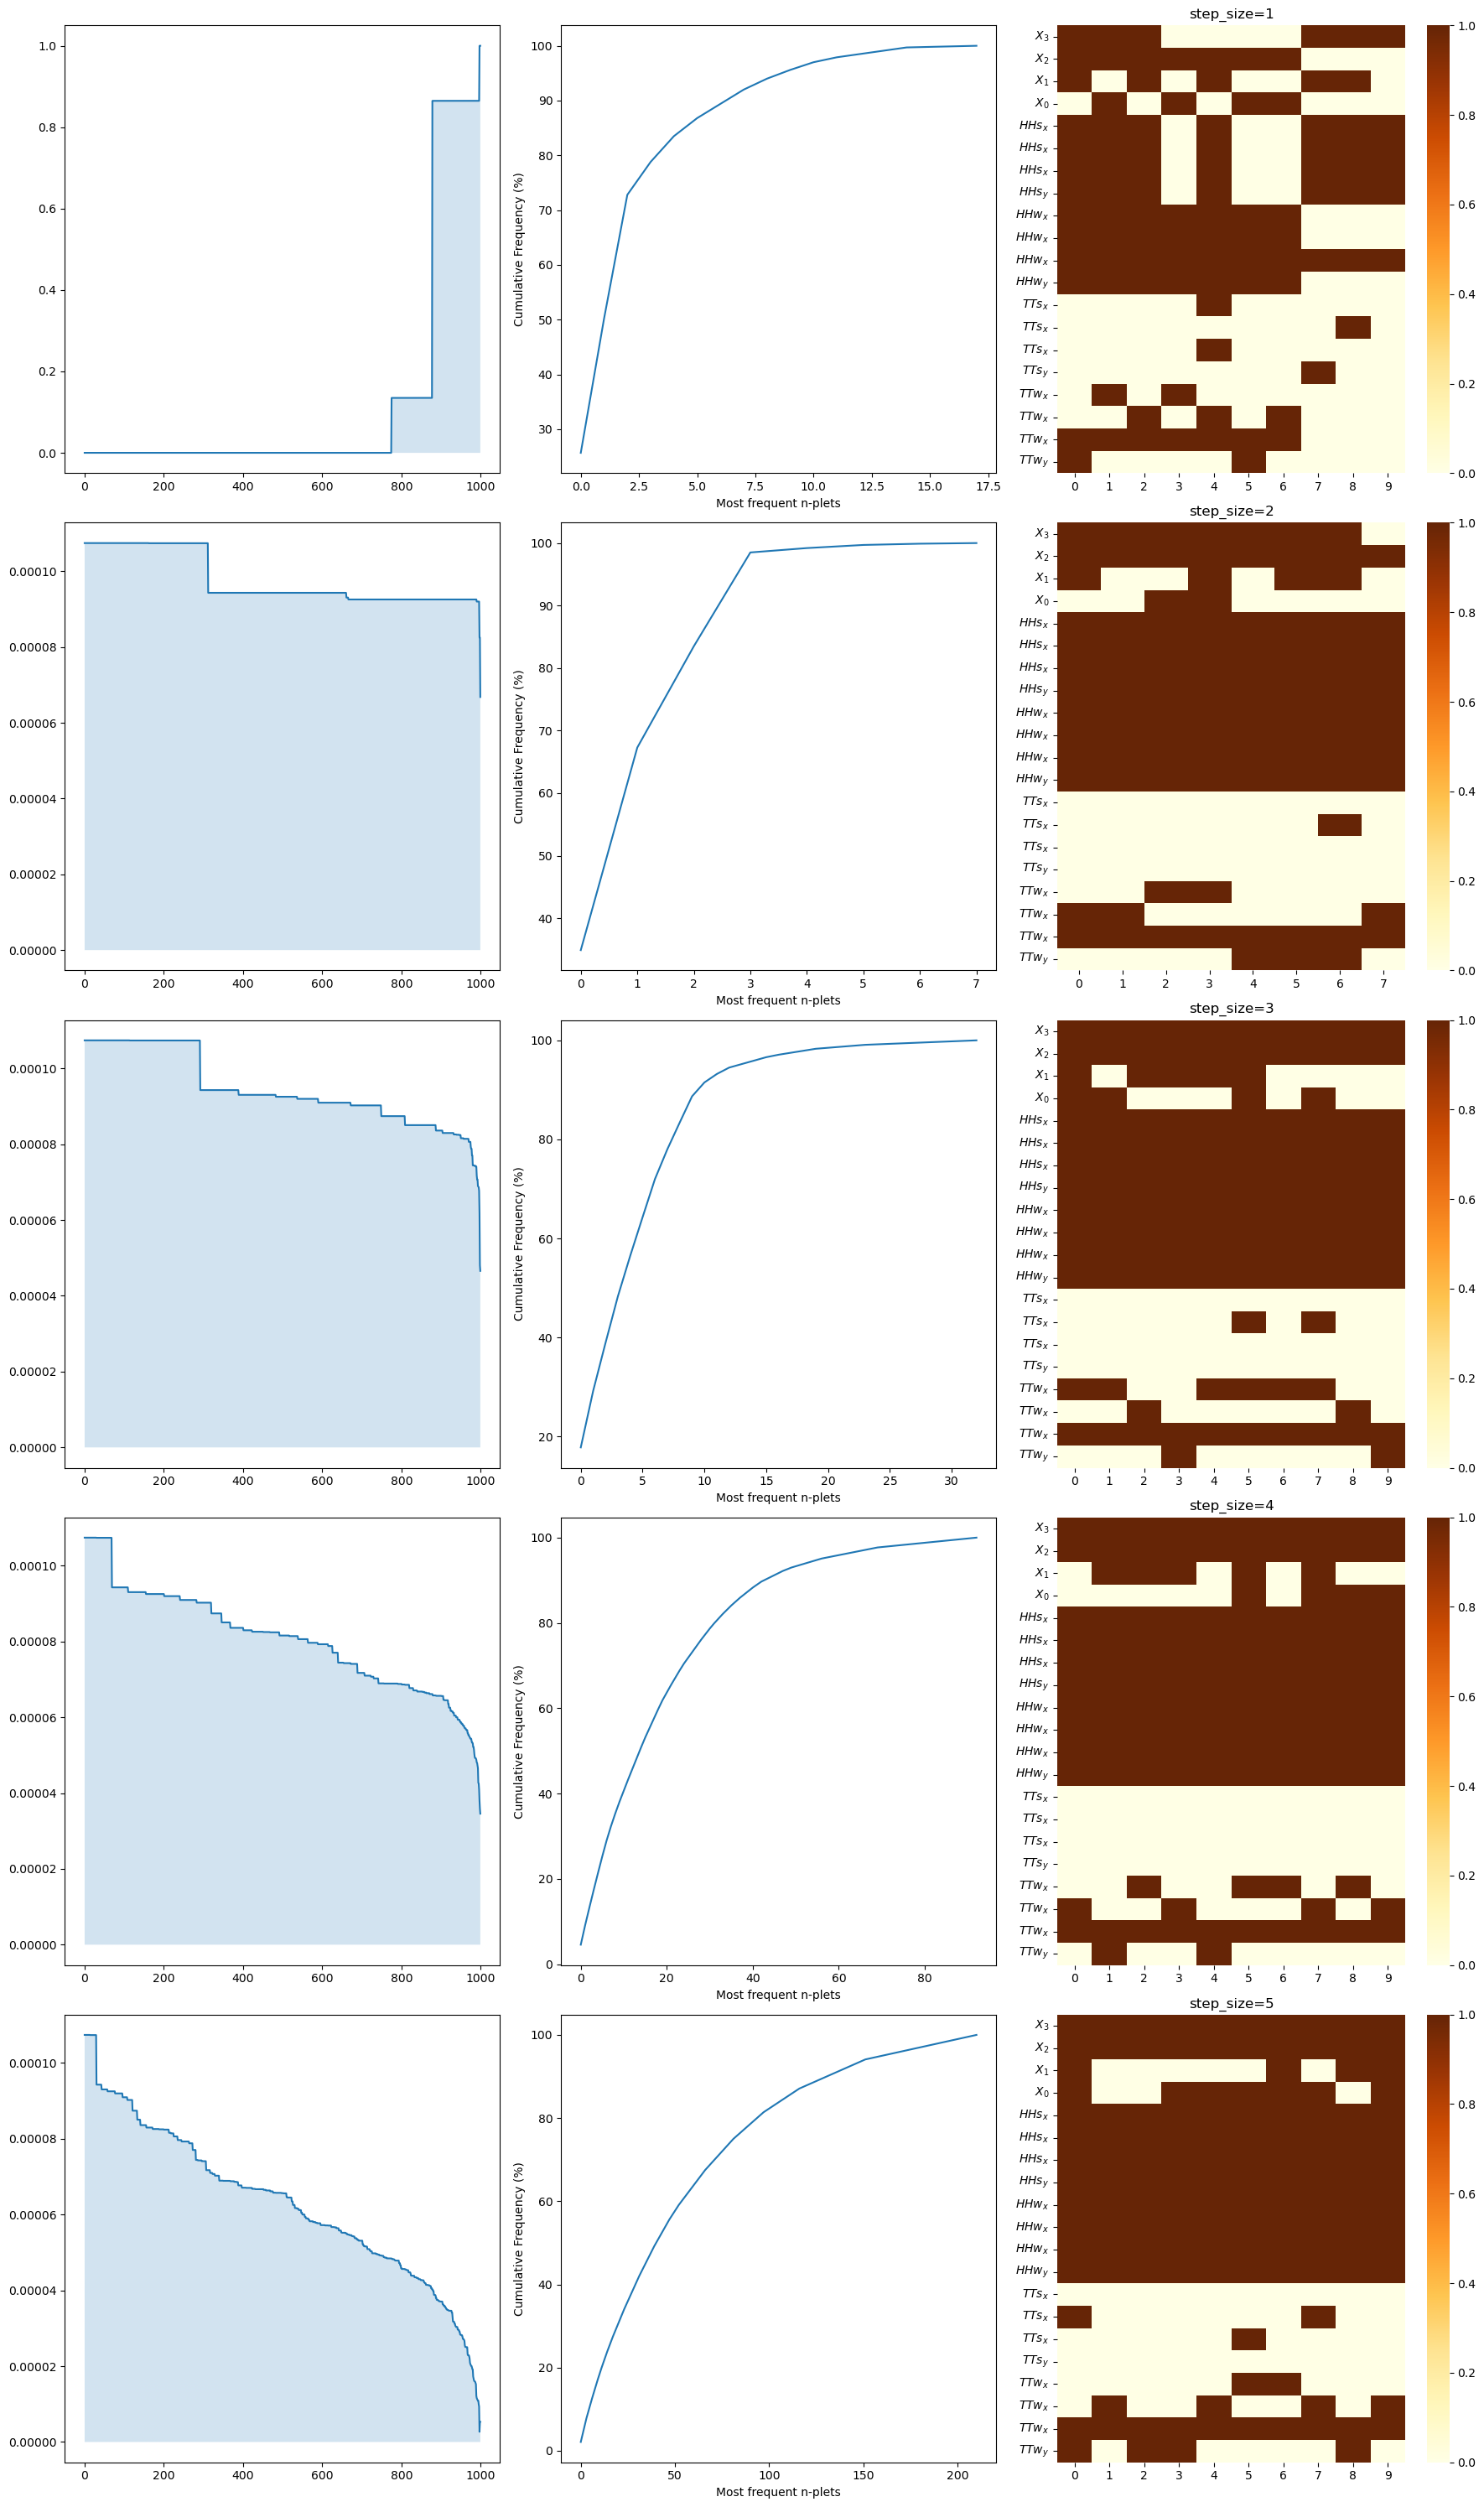

In [5]:
# create two figures side by side
fig, axes = plt.subplots(5, 3, figsize=(3*6, 5*6))

errors = []
rates = []
for step_size in [1, 2, 3, 4, 5]:
    axs = axes[step_size - 1]

    sim_res = simulated_annealing_multi_order(X, repeat=1000, step_size=step_size, use_cpu=True)
    errors.append(weigth_absolute_deviation(sim_res[0]))
    rates.append(single_error_rates(sim_res[0]))

    unique_rows, counts = np.unique(sim_res[0], axis=0, return_counts=True)

    ax = axs[0]
    # sort oinfos
    oinfo = sim_res[1].numpy()
    oinfo = oinfo[np.argsort(oinfo)]
    
    # get relative error with respect to the minimum min_o
    oinfo = np.abs((oinfo - min_o) / min_o)

    # plot the relative error of the oinfos
    sns.lineplot(
        x=list(range(len(oinfo))),
        y=oinfo,
        ax=ax
    )

    # fill the area between the curve and the x axis
    ax.fill_between(list(range(len(oinfo))), oinfo, 0, alpha=0.2)

    ax = axs[1]

    # convert counts to frequencies
    counts = counts * 100 / counts.sum()

    # sort counts descending
    idx = np.argsort(counts)[::-1]
    counts = counts[idx]
    unique_rows = unique_rows[idx]

    # Compute cumulative frequencies
    cumulative_counts = np.cumsum(counts)

    # Plot the cumulative frequencies
    sns.lineplot(
        x=list(range(len(cumulative_counts))),
        y=cumulative_counts,
        ax=ax
    )

    # Label the axes
    ax.set_ylabel('Cumulative Frequency (%)')
    ax.set_xlabel('Most frequent n-plets')

    ax = axs[2]

    # plot the most frequent n-plets
    unique_rows_top = unique_rows[:10]

    # plot the heatmap of the most frequent n-plets
    sns.heatmap(unique_rows_top.T, ax=ax, vmin=0, vmax=1, cmap='YlOrBr')

    # set y labels as var_names
    ax.set_yticks(np.arange(len(var_names)) + 0.5)
    ax.set_yticklabels(var_names, rotation=0)

    ax.set_title('step_size=' + str(step_size))

    # revert heatmap y axis
    ax.invert_yaxis()

# Show the plot
plt.tight_layout()
plt.show()

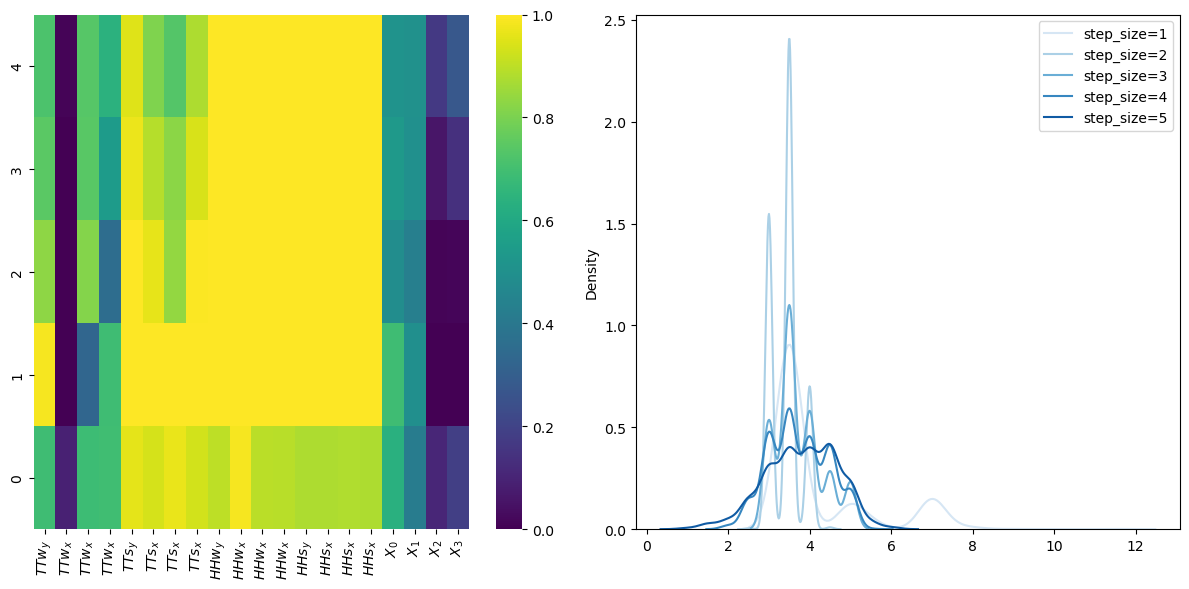

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(2*6, 1*6))

# plot heatmap of errors
ax = axes[0]
sns.heatmap(rates, ax=ax, vmin=0, vmax=1, cmap='viridis')
ax.invert_yaxis()

# set x labels as var_names
ax.set_xticks(np.arange(len(var_names)) + 0.5)
ax.set_xticklabels(var_names, rotation=90)

# plot distributions of errors for each step_size
palette = sns.color_palette("Blues", 5)
ax = axes[1]
for i, error in enumerate(errors):
    sns.kdeplot(error, ax=ax, label=f'step_size={i+1}', color=palette[i])

ax.legend()

# Show the plot
plt.tight_layout()
plt.show()